# Actividad 8: Tarea de regresión y clasificación con redes neuronales
Aprendizaje Automático

Especialización en Inteligencia Artificial

Universidad Autónoma de Manizales

2024

En esta tarea utilizaremos [TensorFlow](https://www.tensorflow.org/) para crear:

 un modelo que clasifique las vocales en nuestro conjunto de

1.   Un modelo que clasifique las vocales de nuestro conjunto de datos.
2.   Un modelo que clasifique el estudiante que escribió una vocal dada.

En ambos casos, se deben tener en cuenta los siguientes pasos:

1.   Creación de un *Dataset* de Tensorflow-Keras para leer las imagenes desde la carpeta compartida de [Drive](https://drive.google.com/drive/folders/1VlepzbxFPI1lNXunHtooUc1_FDnGdO5r?usp=sharing).
2.   Aumentación de los datos utilizando estrategias como rotación y deformación (de ancho y alto).
3.   Definición de

En este caso, puede utilizar las librerías que considere convenientes para solucionar los siguientes puntos.

En cada sección, se sugieren enlaces a la documentación de TensorFlow que ilustran cómo realizar lo solicitado. Mientras que se recomienda leerlos en inglés, si piensa traducir el contenido, procure utilizar el selector de idioma que se encuentra en la parte superior de la página, en lugar de utilizar otra herramienta.


Comenzamos por abordar el primer problema de clasificación, donde la etiqueta es la **vocal** a la que corresponde la imagen.

## Problema 1 (20pts) - Definir los conjuntos de datos para Keras

En este punto usted debe definir *Datasets* para entrenar los modelos de red neuronal.

De manera similar a la ilustrada en [https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control](https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control) (en la sección "*Using tf.data for finer control*"), defina 3 conjuntos de datos:


*   `train_ds`: conjunto de datos de entrenamiento con el 65% de las imagenes.
*   `val_ds`: conjunto de datos de validación con el 10% de las imagenes.
*   `test_ds`: conjunto de datos de prueba con el 25% de los datos.

Al implementar la función `get_label` tenga en cuenta que esta se puede determinar a partir de la ruta del archivo.

Tamaño img 60x60


In [56]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_datasets as tfds

import math
import numpy as np
import matplotlib.pyplot as plt
import logging
import os
import pandas as pd
import cv2
import pathlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder


logger = tf.get_logger()

logger.setLevel(logging.ERROR)

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
ruta_vowels = '/content/drive/MyDrive/VOWELS'
print(os.listdir(ruta_vowels))

['G', 'T', 'J5', 'J2', 'J10', 'J1', 'V2', 'J7', 'J4', 'A', 'V1', 'J6', 'L1', 'J3', 'J12', 'L2', 'J11', 'J9', 'C', 'J8', 'R']


In [59]:
X = []
y = []
y_name = []

for estudiante in os.listdir(ruta_vowels):
  dir_estudiante = os.path.join(ruta_vowels, estudiante)
  for vocal in ['a','e','i','o','u']:
    dir_vocal = os.path.join(dir_estudiante, vocal)
    if os.path.exists(dir_vocal):
      for nombreImagen in os.listdir(dir_vocal):
        dir_image = os.path.join(dir_vocal, nombreImagen)
        img = cv2.imread(dir_image, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (60,60))
        X.append(img_resized)
        y.append(vocal)
        y_name.append(estudiante)

In [60]:
print("Cantidad de imágenes cargadas: ", len(X))
print('Cantidad de etiquetas cargadas: ', len(y))
print('Clases encontradas: ', set(y))

Cantidad de imágenes cargadas:  2000
Cantidad de etiquetas cargadas:  2000
Clases encontradas:  {'o', 'u', 'i', 'e', 'a'}


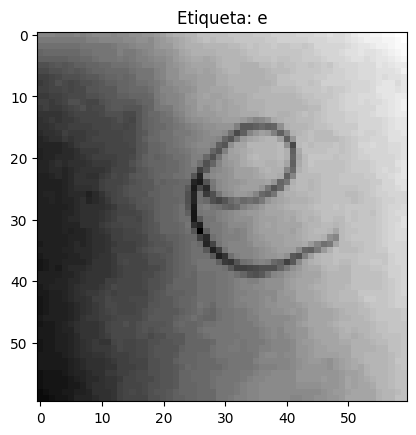

In [61]:
def visualizarDatos(imagen, label=None):
  plt.imshow(imagen, cmap='gray')
  if label:
    plt.title(f"Etiqueta: {label}")
  plt.show()

visualizarDatos(X[800], label = y[800])

In [62]:
classes, counts = np.unique(y, return_counts=True)
print("Etiquetas por clase: ")
for i in range(len(counts)):
  print(classes[i], ": ", counts[i])

Etiquetas por clase: 
a :  400
e :  400
i :  400
o :  400
u :  400


In [63]:
X = np.array(X).reshape(-1, 60, 60, 1)/255.0
y = np.array(y)

In [64]:
label_enconder = LabelEncoder()
y = label_enconder.fit_transform(y)

In [65]:
classes, counts = np.unique(y, return_counts=True)
print("Etiquetas por clase: ")
for i in range(len(counts)):
  print(classes[i], ": ", counts[i])

Etiquetas por clase: 
0 :  400
1 :  400
2 :  400
3 :  400
4 :  400


In [66]:
print('Clases encontradas: ', set(y))

Clases encontradas:  {0, 1, 2, 3, 4}


In [67]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.35, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.71428, random_state=42, stratify=y_valid)

In [68]:
len(X_train)

1300

In [69]:
len(X_valid)

200

In [70]:
len(X_test)

500

## Problema 2 (20pts) - Preprocesamiento y Aumentación de Datos

En base a los ejemplos de [https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers](https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers) (sección *Use Keras preprocessing layers*),

Tenga en cuenta que el preprocesamiento se aplica a todos los conjuntos de datos, pero **la aumentación se aplica únicamente a los datos de entrenamiento**.

Note que si incluye las capas de preprocesamiento y aumentación de datos dentro del modelo, las capas de preprocesamiento siempre se aplican pero las de aumentación sólo aplican durante el entrenamiento. Ver [capas de preprocesamiento de imagenes](https://www.tensorflow.org/guide/keras/preprocessing_layers#image_preprocessing) y [capas de aumentación de imagenes](https://www.tensorflow.org/guide/keras/preprocessing_layers#image_data_augmentation) para más información.

Considere al menos aumentaciones basadas en:
*   Random rotation
*   Random translation
*   Random zoom

En todos los casos, utilice parámetros que mantengan los cambios moderados.



In [71]:
aumentoDatos = tf.keras.Sequential([
    #layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.05),
    layers.RandomTranslation(0.05, 0.05),
])

batch_size = 32

train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(len(X_train))
    .batch(batch_size)
    .map(lambda x, y: (aumentoDatos(x), y))
    .prefetch(tf.data.AUTOTUNE)
)

valid_dataset = (
    tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [72]:
len(train_dataset)

41

In [73]:
for imagen, etiqueta in train_dataset.take(1):
  print("Lote de imágenes: ", imagen.shape)
  print("Lote de etiquetas: ", etiqueta.shape)

Lote de imágenes:  (32, 60, 60, 1)
Lote de etiquetas:  (32,)


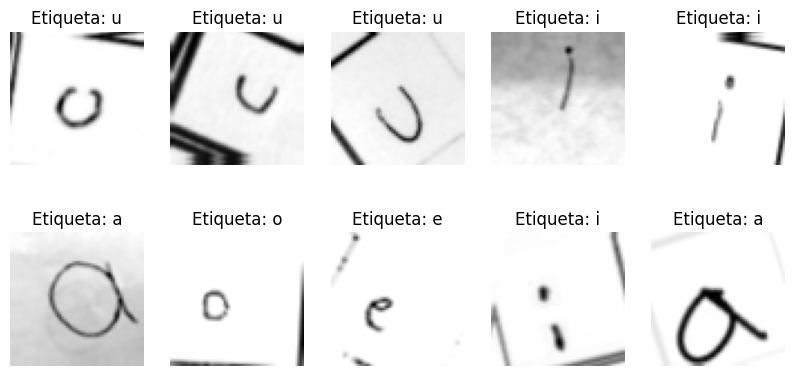

In [74]:
etiquetas_vocales = {0: 'a', 1: 'e', 2: 'i', 3: 'o', 4: 'u'}

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(10):
        plt.subplot(4, 5, i+1)
        plt.imshow(images[i].numpy().reshape(60, 60), cmap="gray")

        vocal = etiquetas_vocales[labels[i].numpy()]
        plt.title(f"Etiqueta: {vocal}")
        plt.axis('off')
    plt.show()

## Problema 3 (20pts) - Construcción y elección del modelo
En este problema usted debe construir modelos de red neuronal convolucional para este problema y evaluarlos utilizando datos de validación y las métricas vistas durante el curso.


### Creación de modelos

En esta sección usted debe definir dos o más modelos de red neuronal convolucional para el problema de clasificación de vocales.

Considere variaciones de los siguientes aspectos de los modelos:

*   Número de capas de convolución, número de filtros y su tamaño (ej: 3x3, 5x5).
*   Capas de pooling, su tipo (max, avg) y tamaño (ej: 2x2).
*   Número de capas ocultas y cantidad de unidades en ellas.
*   Capas de dropout y su intensidad.

Dependiendo de su elección en el problema anterior, el modelo debe incluir las capas de preprocesamiento y aumentación.

Las capas de entrada y salida están determinadas por el problema.


In [75]:
model_1 = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(60, 60, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='sigmoid')
])


model_2 = tf.keras.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(60, 60, 1)),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='sigmoid')
])


model_3 = tf.keras.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(60, 60, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='sigmoid')
])


model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [76]:
history1 = model_1.fit(train_dataset, validation_data=valid_dataset, epochs=20, verbose=1)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.2174 - loss: 1.6177 - val_accuracy: 0.3300 - val_loss: 1.5500
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.2971 - loss: 1.5378 - val_accuracy: 0.4600 - val_loss: 1.2461
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.4646 - loss: 1.3198 - val_accuracy: 0.6500 - val_loss: 0.8950
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.5371 - loss: 1.1302 - val_accuracy: 0.7350 - val_loss: 0.6897
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.6402 - loss: 0.9205 - val_accuracy: 0.7850 - val_loss: 0.5397
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.6760 - loss: 0.8276 - val_accuracy: 0.8900 - val_loss: 0.4094
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.7018 - loss: 0.7229 - val_accuracy: 0.8100 - val_loss: 0.4462
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.7488 - loss: 0.6515 - val_accuracy: 

In [77]:
history2 = model_2.fit(train_dataset, validation_data=valid_dataset, epochs=20, verbose=1)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.2094 - loss: 1.6090 - val_accuracy: 0.2250 - val_loss: 1.6092
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.1905 - loss: 1.6093 - val_accuracy: 0.1950 - val_loss: 1.6009
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.2306 - loss: 1.5846 - val_accuracy: 0.4950 - val_loss: 1.3060
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.4456 - loss: 1.3499 - val_accuracy: 0.6150 - val_loss: 1.0104
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.5496 - loss: 1.1234 - val_accuracy: 0.6150 - val_loss: 0.8940
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5773 - loss: 1.0187 - val_accuracy: 0.7350 - val_loss: 0.7580
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.6411 - loss: 0.8777 - val_accuracy: 0.7650 - val_loss: 0.6559
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6623 - loss: 0.7979 - val_accuracy: 0.7350

In [78]:
history3 = model_3.fit(train_dataset, validation_data=valid_dataset, epochs=20, verbose=1)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 262ms/step - accuracy: 0.2109 - loss: 1.6344 - val_accuracy: 0.2850 - val_loss: 1.5820
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 274ms/step - accuracy: 0.2993 - loss: 1.5412 - val_accuracy: 0.5900 - val_loss: 1.1731
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.4555 - loss: 1.3175 - val_accuracy: 0.7050 - val_loss: 0.8776
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 278ms/step - accuracy: 0.5825 - loss: 1.1299 - val_accuracy: 0.8150 - val_loss: 0.6879
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 283ms/step - accuracy: 0.6492 - loss: 0.9414 - val_accuracy: 0.8500 - val_loss: 0.5268
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.6937 - loss: 0.8037 - val_accuracy: 0.8750 - val_loss: 0.4423
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 279ms/step - accuracy: 0.7280 - loss: 0.7020 - val_accuracy: 0.8900 - val_loss: 0.3972
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 210ms/step - accuracy: 0.7748 - loss: 0.6476 - val_accura

### Validación de los modelos

Evalue los modelos utilizando los datos de validación y
Además de la creación de los modelos, su solución a este problema debe evidencia lo siguiente:

1.   Gráficas de curvas de aprendizaje para detectar sobreajuste/desajuste.
1.   Comparación de las métricas de los modelos en entrenamiento y validación.
1.   Matrices de confusión y métricas asociadas.
1.   Discusión de los resultados y elección de un modelo.

Opcional: Puede realizar la búsqueda de hiperparámetros utilizando [HParams](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams)


Classification Report - Model 1:
               precision    recall  f1-score   support

           a       0.94      0.92      0.93       100
           e       0.90      0.98      0.94       100
           i       0.95      0.99      0.97       100
           o       0.91      0.84      0.88       100
           u       0.99      0.96      0.97       100

    accuracy                           0.94       500
   macro avg       0.94      0.94      0.94       500
weighted avg       0.94      0.94      0.94       500



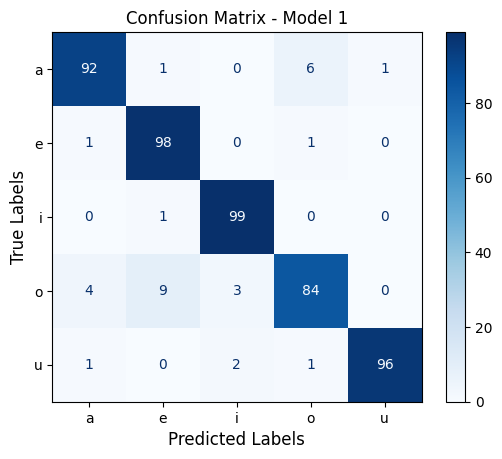

Classification Report - Model 2:
               precision    recall  f1-score   support

           a       0.84      0.76      0.80       100
           e       0.86      0.93      0.89       100
           i       0.90      0.91      0.91       100
           o       0.80      0.72      0.76       100
           u       0.89      0.99      0.94       100

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500



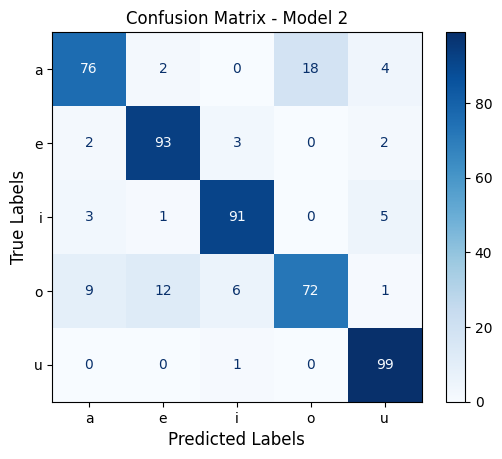

Classification Report - Model 3:
               precision    recall  f1-score   support

           a       0.94      0.82      0.88       100
           e       0.90      0.95      0.92       100
           i       0.92      0.98      0.95       100
           o       0.84      0.85      0.85       100
           u       0.97      0.96      0.96       100

    accuracy                           0.91       500
   macro avg       0.91      0.91      0.91       500
weighted avg       0.91      0.91      0.91       500



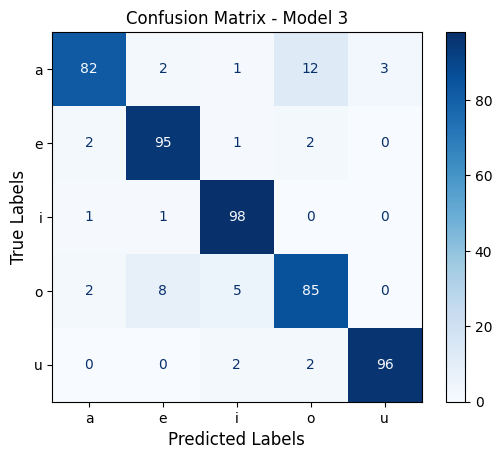

In [111]:
labels = ['a', 'e', 'i', 'o', 'u']

def plot_confusion_matrix(cm, model_name):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.grid(False)
    plt.show()

cm_1 = confusion_matrix(y_test, y_pred_1, labels=range(len(labels)))
print("Classification Report - Model 1:\n", classification_report(y_test, y_pred_1, target_names=labels))
plot_confusion_matrix(cm_1, "Model 1")

cm_2 = confusion_matrix(y_test, y_pred_2, labels=range(len(labels)))
print("Classification Report - Model 2:\n", classification_report(y_test, y_pred_2, target_names=labels))
plot_confusion_matrix(cm_2, "Model 2")

cm_3 = confusion_matrix(y_test, y_pred_3, labels=range(len(labels)))
print("Classification Report - Model 3:\n", classification_report(y_test, y_pred_3, target_names=labels))
plot_confusion_matrix(cm_3, "Model 3")


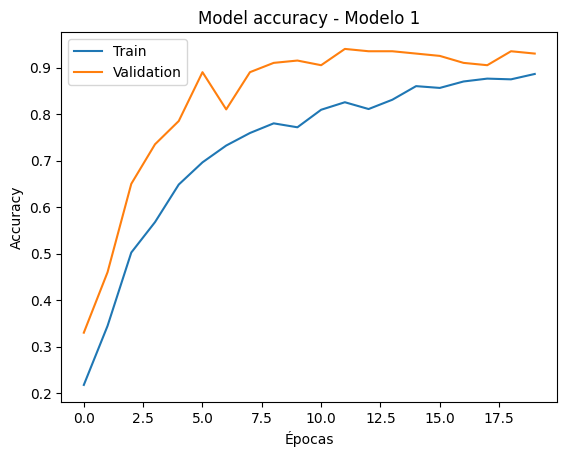

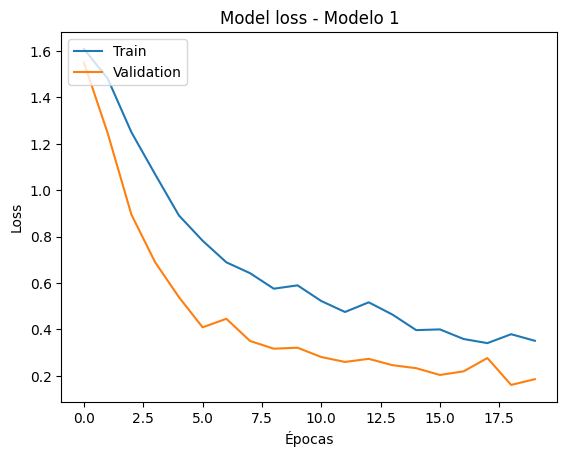

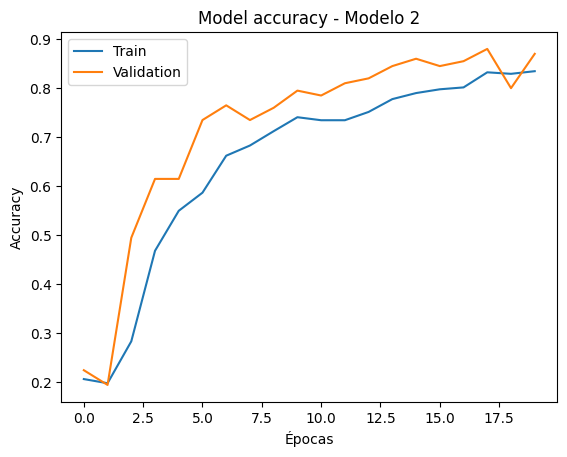

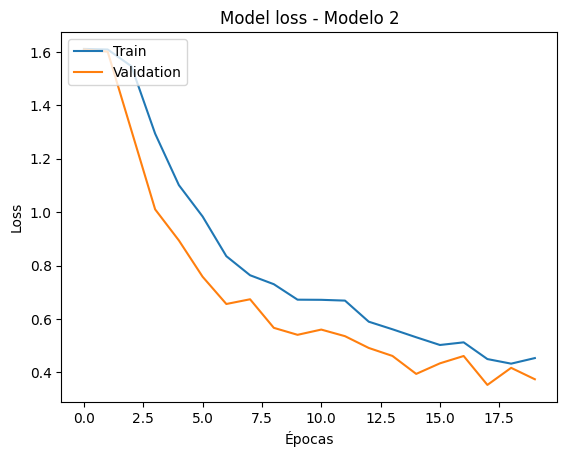

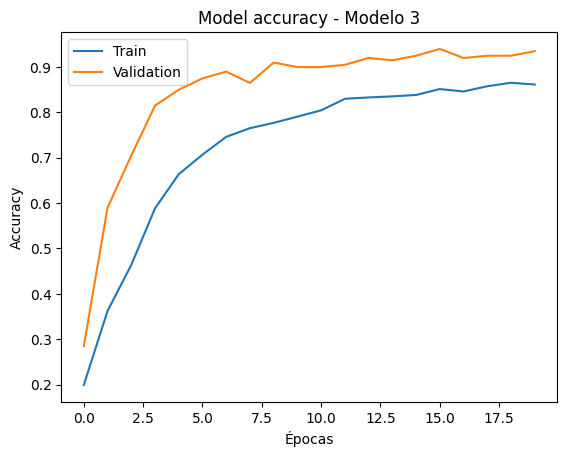

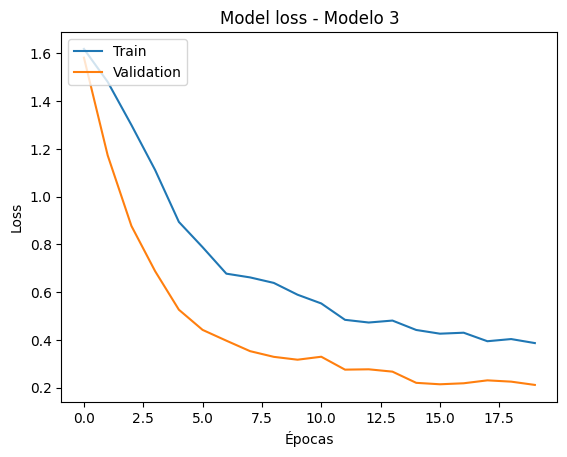

In [97]:
def plot_accuracy(history, model_name):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy - ' + model_name)
  plt.ylabel('Accuracy')
  plt.xlabel('Épocas')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

def plot_loss(history, model_name):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss - ' + model_name)
  plt.ylabel('Loss')
  plt.xlabel('Épocas')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()


plot_accuracy(history1, 'Modelo 1')
plot_loss(history1, 'Modelo 1')

plot_accuracy(history2, 'Modelo 2')
plot_loss(history2, 'Modelo 2')

plot_accuracy(history3, 'Modelo 3')
plot_loss(history3, 'Modelo 3')

In [98]:
test_dataset = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


In [99]:
yp = model_1.predict(test_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


In [100]:
yp[0]

array([0.26819623, 0.02528044, 0.9968951 , 0.08753128, 0.5976614 ],
      dtype=float32)

In [101]:
y_predictions = np.argmax(yp,axis=1)

In [102]:
y_predictions[0]

2

## Problema 4 (20pts) - Evaluación del modelo y discusión

Evalue el modelo utilizando los datos de prueba.

*   ¿Qué tan bueno fue el desempeño del modelo? (Haga referencia a los resultados obtenidos con los datos de prueba y su comparación con lo visto en entrenamiento y validación.)

* Podemos observar que el modelo 1 muestra una alta capacidad de generalización, con métricas consistentes en entrenamiento y prueba, lo que indica que no sufre de overfitting ni underfitting. En el caso del modelo 2 parece que tiene problemas de generalización, ya que sus métricas son notablemente más bajas, posiblemente debido a un entrenamiento insuficiente o una arquitectura menos robusta. Y en cuanto al modelo 3, este tiene un desempeño intermedio, indicando un buen balance, aunque es ligeramente inferior al modelo 1.

*   ¿Cuáles son las vocales más fáciles y más difíciles de identificar? (En este punto utilice una matriz de confusión con los resultados del modelo en datos de **prueba**.)

* Las clase "o" fue la más difícil de clasificar correctamente, lo cual podría deberse a patrones menos distintivos en sus características.
* Las clases "i" y "u" fueron al parecer las más fáciles de clasificar en los tres modelos, destacando como una clase bien definida y un número bajo de errores.

*   Ofrezca conclusiones finales sobre el problema de clasificación de vocales y los resultados obtenidos.

* El modelo 1 es el más adecuado para el problema de clasificación de vocales, debido a su alto desempeño global y consistencia en todas las clases. Su exactitud del 94% lo hace superior.
* La confusión entre las vocales "o", "e" y "a" sugiere similitudes en las características utilizadas por el modelo para clasificar. Esto podría deberse a patrones menos distintivos en los datos.
* Los modelos funcionaron mejor a un número alto de épocas (20) y menor número de capas aumentando sus metricas a favor.
* Se intentó agregar regularización L2 a las capas, pero resultó en la disminución de la precisión.
* El problema de clasificación de vocales se resolvió de manera efectiva, con el modelo 1 ofreciendo un balance óptimo entre precisión, recall y F1-score.


## Problema 5 (20pts) - Clasificación de autores

En este problema usted deberá realizar nuevamente las acciones de los problemas 1 al 4, esta vez para solucionar el problema de clasificación de autores de las vocales. Es decir, en esta ocasión, la etiqueta a predecir es el nombre del estudiante que escribió la letra.

### Definición de los conjuntos de datos
La mayor parte del proceso es igual, excepto por la definición de los nombres de las clases y la función `get_label` que ahora debe devolver el nombre del estudiante en lugar del nombre de la vocal.

In [103]:
label_enconder = LabelEncoder()
y_name = label_enconder.fit_transform(y)

In [104]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_name, test_size=0.35, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.71428, random_state=42, stratify=y_valid)

In [105]:
len(X_train)

1300

In [106]:
len(X_valid)

200

In [107]:
len(X_test)

500

### Preprocesamiento y Aumentación
Esta porción debería ser idéntica a la anterior, ya que esta se aplica sobre las imágenes (características) y no sobre las etiquetas.

In [112]:
aumentoDatos = tf.keras.Sequential([
    #layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.05),
    layers.RandomTranslation(0.05, 0.05),
])

batch_size = 32

train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(len(X_train))
    .batch(batch_size)
    .map(lambda x, y: (aumentoDatos(x), y))
    .prefetch(tf.data.AUTOTUNE)
)

valid_dataset = (
    tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [127]:
len(train_dataset)

41

In [128]:
for imagen, etiqueta in train_dataset.take(1):
  print("Lote de imágenes: ", imagen.shape)
  print("Lote de etiquetas: ", etiqueta.shape)

Lote de imágenes:  (32, 60, 60, 1)
Lote de etiquetas:  (32,)


### Construcción y elección del modelo

Esta parte del proceso de desarrolla de manera similar a la anterior. Sin embargo, debe probar distintas configuraciones del modelo ya que, al cambiar la tarea, puede cambiar la configuración óptima.

In [115]:
model_4 = models.Sequential([
  layers.Input(shape=(60, 60, 1)),
  layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(21, activation='softmax')
  ])

model_5 = models.Sequential([
    layers.Input(shape=(60,60,1)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(21, activation = 'softmax')
])

model_4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_5.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [116]:
history4 = model_4.fit(train_dataset, validation_data=valid_dataset, epochs=25, verbose=1)

Epoch 1/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 275ms/step - accuracy: 0.1847 - loss: 2.1684 - val_accuracy: 0.3600 - val_loss: 1.4864
Epoch 2/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - accuracy: 0.2888 - loss: 1.5997 - val_accuracy: 0.5600 - val_loss: 1.1351
Epoch 3/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 249ms/step - accuracy: 0.4642 - loss: 1.3237 - val_accuracy: 0.6050 - val_loss: 1.0254
Epoch 4/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 381ms/step - accuracy: 0.5232 - loss: 1.1981 - val_accuracy: 0.7050 - val_loss: 0.7812
Epoch 5/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 311ms/step - accuracy: 0.5879 - loss: 1.0494 - val_accuracy: 0.7500 - val_loss: 0.6952
Epoch 6/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 0.6346 - loss: 0.9772 - val_accuracy: 0.7950 - val_loss: 0.5992
Epoch 7/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.6513 - loss: 0.9007 - val_accuracy: 0.8150 - val_loss: 0.5450
Epoch 8/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.6642 - loss: 0.8635 - val_accurac

In [117]:
history5 = model_5.fit(train_dataset, validation_data=valid_dataset, epochs=25, verbose=1)

Epoch 1/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.1670 - loss: 2.3287 - val_accuracy: 0.3700 - val_loss: 1.5888
Epoch 2/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 257ms/step - accuracy: 0.2558 - loss: 1.6756 - val_accuracy: 0.2400 - val_loss: 1.6444
Epoch 3/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 282ms/step - accuracy: 0.3584 - loss: 1.5518 - val_accuracy: 0.4550 - val_loss: 1.3496
Epoch 4/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 434ms/step - accuracy: 0.3666 - loss: 1.4464 - val_accuracy: 0.5550 - val_loss: 1.1190
Epoch 5/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 419ms/step - accuracy: 0.4360 - loss: 1.3000 - val_accuracy: 0.5550 - val_loss: 1.1643
Epoch 6/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 394ms/step - accuracy: 0.5114 - loss: 1.2526 - val_accuracy: 0.6700 - val_loss: 0.9398
Epoch 7/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 307ms/step - accuracy: 0.5342 - loss: 1.1521 - val_accuracy: 0.6150 - val_loss: 0.9794
Epoch 8/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 263ms/step - accuracy: 0.5716 - loss: 1.0877 - val_accu

### Evaluación del modelo y discusión
Siga las mismas instrucciones del problema 4 para realizar esta sección con respecto a la clasificación de autores.

In [130]:
labels = ['a', 'e', 'i', 'o', 'u']

def plot_confusion_matrix(cm, model_name):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.grid(False)
    plt.show()


y_pred_4 = model_4.predict(X_test)
y_pred_4 = y_pred_4.argmax(axis=1)


cm_4 = confusion_matrix(y_test, y_pred_4, labels=range(len(labels)))
print("Classification Report - Model 4:\n", classification_report(y_test, y_pred_4, target_names=labels))
#plot_confusion_matrix(cm_4, "Model 4")


y_pred_5 = model_5.predict(X_test)
y_pred_5 = y_pred_5.argmax(axis=1)


cm_5 = confusion_matrix(y_test, y_pred_5, labels=range(len(labels)))
print("Classification Report - Model 5:\n", classification_report(y_test, y_pred_5, target_names=labels))
#plot_confusion_matrix(cm_5, "Model 5")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step
Classification Report - Model 4:
               precision    recall  f1-score   support

           a       0.90      0.89      0.89       100
           e       0.87      0.99      0.93       100
           i       0.95      0.93      0.94       100
           o       0.93      0.74      0.82       100
           u       0.90      0.98      0.94       100

    accuracy                           0.91       500
   macro avg       0.91      0.91      0.90       500
weighted avg       0.91      0.91      0.90       500

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
Classification Report - Model 5:
               precision    recall  f1-score   support

           a       0.78      0.87      0.82       100
           e       0.88      0.92      0.90       100
           i       0.98      0.91      0.94       100
           o       0.82      0.81      0.81       100
           u       0.91      0.85      0.88       100

    accuracy                         

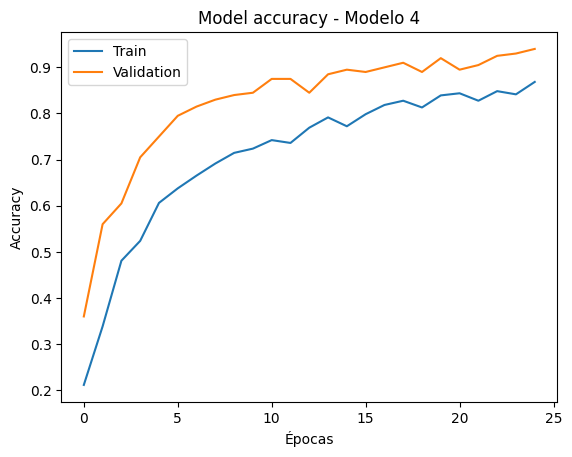

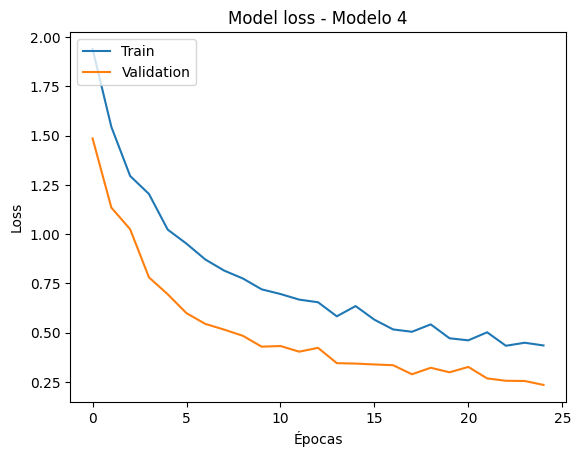

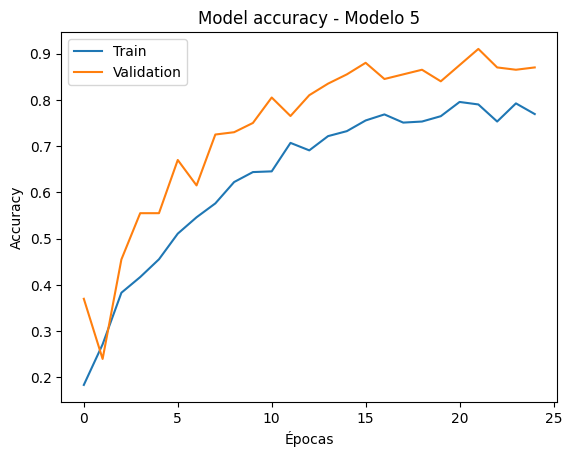

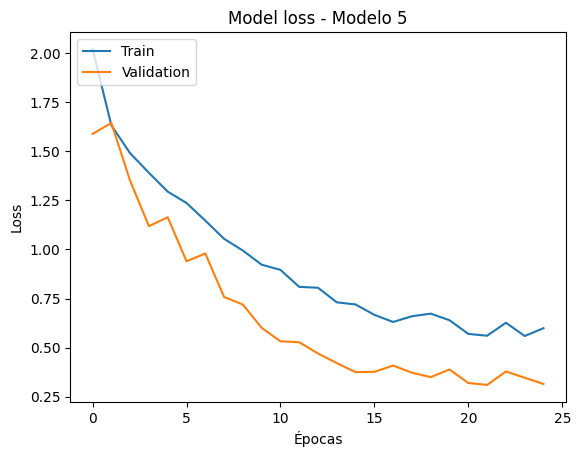

In [129]:
def plot_accuracy(history, model_name):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy - ' + model_name)
  plt.ylabel('Accuracy')
  plt.xlabel('Épocas')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

def plot_loss(history, model_name):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss - ' + model_name)
  plt.ylabel('Loss')
  plt.xlabel('Épocas')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()


plot_accuracy(history4, 'Modelo 4')
plot_loss(history4, 'Modelo 4')

plot_accuracy(history5, 'Modelo 5')
plot_loss(history5, 'Modelo 5')

In [122]:
test_dataset = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


In [123]:
yp = model_4.predict(test_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step


In [124]:
yp[0]

array([4.2058937e-03, 9.8580611e-04, 9.8828143e-01, 2.5120059e-03,
       4.0118243e-03, 2.5629532e-07, 1.0300287e-07, 3.1202904e-07,
       1.0178596e-07, 4.2048416e-08, 5.8685043e-07, 7.6033304e-09,
       2.6236591e-09, 3.2868788e-09, 4.9130147e-08, 3.8469839e-08,
       8.1277204e-07, 1.9861057e-08, 3.0131304e-07, 1.9332084e-08,
       3.8105816e-07], dtype=float32)

In [125]:
y_predictions = np.argmax(yp,axis=1)

In [126]:
y_predictions[0]

2

Evalue el modelo utilizando los datos de prueba.

*   ¿Qué tan bueno fue el desempeño del modelo? (Haga referencia a los resultados obtenidos con los datos de prueba y su comparación con lo visto en entrenamiento y validación.)

* Podemos observar que el modelo 4 muestra una alta capacidad de generalización, con un balance adecuado entre precisión y recall. En el caso del modelo 5 parece que tiene un desempeño inferior en prueba respecto a validación, lo que podría ser indicios de overfitting, donde el modelo ajustó demasiado a los datos de entrenamiento pero no generalizó bien.


*   Ofrezca conclusiones finales sobre el problema de clasificación de vocales y los resultados obtenidos.

* El modelo 4 es el más confiable, con un desempeño general más alto y mejor equilibrio en las métricas.
Aunque el Modelo 5 tiene un rendimiento aceptable, su exactitud y consistencia son inferiores.
* Los modelos funcionaron mejor a un número alto de épocas (25) aumentando sus metricas a favor.
* Se modificó el optimizador pero el que mejor resultados mostró fue Adam
* Se intentó agregar regularización L2 a las capas, pero resultó en la disminución de la precisión.
* Se obtuvo un posible solución para el problema de clasificación de autores con el modelo 4 ofreciendo un balance óptimo entre precisión, recall y F1-score.